In [1]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torch.utils.data import Subset
from sklearn.impute import SimpleImputer, KNNImputer
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.nn.functional import interpolate

%autoreload 2
from datasets import UndersampledUltrasoundDataset3D, MaskedUltrasoundDataset2D
import matplotlib.pyplot as plt
import numpy as np
from utils import set_seed


# MRI Dataset 

In [2]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def resize(x, nc, h, w):
    return torch.nn.functional.interpolate(x.unsqueeze(0).unsqueeze(0), size=(nc, h, w)).squeeze(0).squeeze(0)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x

def create_mask(size, width, spacing):
    assert len(size) == len(width) == len(spacing)
    m = torch.ones(size)
    idxs = []
    for i in range(len(size)):
        wd, sp, s, = width[i], spacing[i], size[i]
        idx = []
        if wd > 0:
            for j in range(int(s / (wd + sp)) + 1):
                idx+= [j*(wd+sp) + k for k in range(wd)]
        else:
            idx += [j for j in range(s)]
        idx = [k for k in idx if k < s]
        idxs.append(torch.tensor(idx))
    idmesh = torch.meshgrid(*idxs)
    m[idmesh] = 0.
    return m


In [15]:
n = 256
path = os.path.abspath("/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal/")
train_transform = Compose([
                    Resize(n),
                    Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x, "outer")),
                    Lambda(lambda x: scale2range(x, [-1., 1.])),
                    # Normalize([0.09779735654592514], [0.16085614264011383])
                    ])

mask = create_mask((n,n), (0,3), (0,1))

ds = MaskedUltrasoundDataset2D(path, 
                                    mode="mri",
                                    transform=train_transform,
                                    mask=mask,
                                    maxsamples=1)
print(ds)

set_seed(42)
valid_ratio = 0.3
i = int(len(ds)*valid_ratio)

idxs = np.arange(0, len(ds), 1)
np.random.shuffle(idxs)

train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)

print(len(trainds), len(validds))

                                    
sample_input, sample_target = validds[0]
# idx = int(sample_input.shape[0]/2)
print(sample_input.shape)

{'name': 'MaskedUltrasoundDataset2D', 'path': '/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal', 'maxsamples': 1, 'transform': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    Lambda()
    Lambda()
    Lambda()
), 'mask': tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]]), 'mode': 'mri', 'len': 1}
0 1
torch.Size([1, 256, 256])


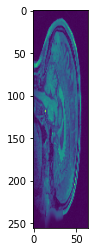

/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


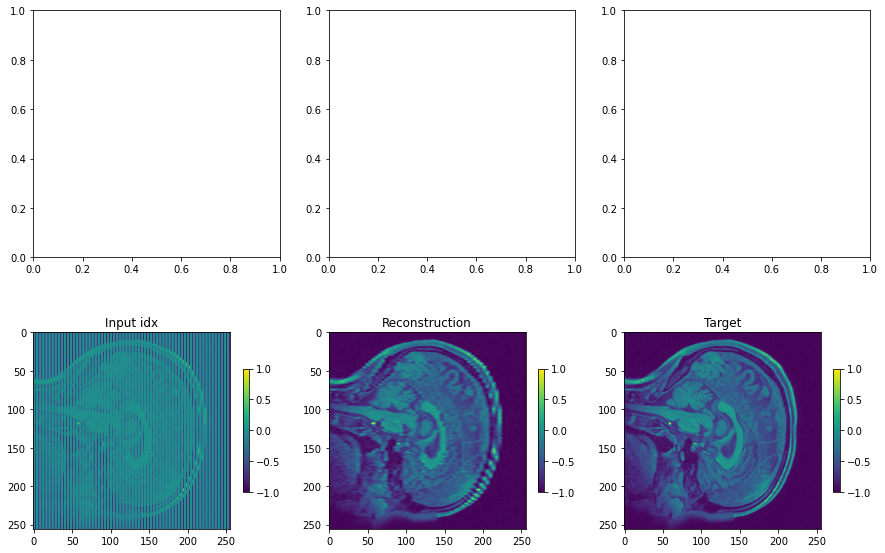

In [17]:
# Interpolation
X = sample_input[0].numpy()
X_ = KNNImputer(missing_values=0.).fit_transform(X)
X_ = torch.tensor(X_).unsqueeze(0).unsqueeze(0)
plt.imshow(X_[0][0])
plt.show()
recon = interpolate(X_, (n, n), mode="bicubic")[0][0].cpu().detach().numpy()

np.save("/home/dp4018/scripts/AWLoss/examples/imputation/comparison/bicubic_3_1.npy", np.rot90(recon))
# Plots
fig, axs = plt.subplots(2,3, figsize=(15, 10))
axs = axs.flatten()

# Plot sample input
im = axs[3].imshow(sample_input[0], vmin=-1., vmax=1.)
fig.colorbar(im, ax=axs[3], shrink=0.5)
axs[3].set_title("Input idx")

# Plot reconstruction
im = axs[4].imshow(recon, vmin=-1., vmax=1.)
fig.colorbar(im, ax=axs[4], shrink=0.5)
axs[4].set_title("Reconstruction")


# Plot target input
im = axs[5].imshow(sample_target[0], vmin=-1., vmax=1.)
fig.colorbar(im, ax=axs[5], shrink=0.5)
axs[5].set_title("Target")

plt.show()


In [18]:
sample_input.shape

torch.Size([1, 256, 256])

In [19]:
np.save("/home/dp4018/scripts/AWLoss/examples/imputation/comparison/masked_3_1.npy", np.rot90(sample_input[0]))
np.save("/home/dp4018/scripts/AWLoss/examples/imputation/comparison/target_3_1.npy", np.rot90(sample_target[0]))